In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()
print('Tensorflow version: %s' % str(tf.__version__))

Tensorflow version: 2.0.0


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import sys
import os
if sys.platform.startswith('darwin'):
    print('enable multiple instances of OpenMP on macOS')
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

enable multiple instances of OpenMP on macOS


In [4]:
print('Prepare minist dataset')
# download from web
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
print('shape of training data %s -> %s' % (str(x_train.shape), str(y_train.shape)))

Prepare minist dataset
shape of training data (60000, 28, 28) -> (60000,)


Display first 6 training image


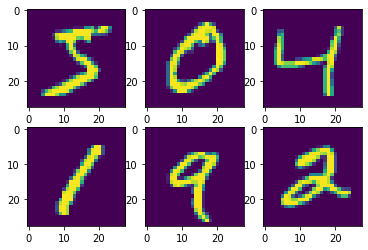

In [5]:
print('Display first 6 training image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x_train[i,:,:].reshape(28,28))

In [6]:
print('Use simple model')
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test,  y_test, verbose=2)

Use simple model
Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 11s 182us/sample - loss: 0.2925 - accuracy: 0.9138
Epoch 2/5
60000/60000 [==============================] - 10s 172us/sample - loss: 0.1433 - accuracy: 0.9583
Epoch 3/5
60000/60000 [==============================] - 9s 145us/sample - loss: 0.1077 - accuracy: 0.9676
Epoch 4/5
60000/60000 [==============================] - 9s 147us/sample - loss: 0.0891 - accuracy: 0.9724
Epoch 5/5
60000/60000 [==============================] - 9s 145us/sample - loss: 0.0754 - accuracy: 0.9765
10000/1 - 1s - loss: 0.0395 - accuracy: 0.9768


[0.07719405731330625, 0.9768]

In [7]:
print('Add a channels dimension')
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
print('Current training data shape: %s' % str(x_train.shape))

Add a channels dimension
Current training data shape: (60000, 28, 28, 1)


In [8]:
print('Prepare data sets for traning and test')
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

Prepare data sets for traning and test


In [9]:
print('Generate special model for this problem')
class HandWritingModel(tf.keras.Model):
    def __init__(self):
        super(HandWritingModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(128, activation='relu')
        self.d2 = tf.keras.layers.Dense(10, activation='softmax')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

spec_model = HandWritingModel()

Generate special model for this problem


In [10]:
print('Prepare loss function and optimizer')
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Prepare loss function and optimizer


In [11]:
print('Define training function by using gradient method')
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = spec_model(images)
        loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, spec_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, spec_model.trainable_variables))
        train_loss(loss)
        train_accuracy(labels, predictions)

print('Define test function')
@tf.function
def test_step(images, labels):
    predictions = spec_model(images)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)


Define training function by using gradient method
Define test function


In [12]:
print('Use specific model to train')
for epoch in range(5):
    train_loss.reset_states() # reset loss and accuracy at the beginning of every step
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:#train model by using every batch in traning dataset
        train_step(images, labels)
    for test_images, test_labels in test_ds:#test model by using every batch in test dataset
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,train_loss.result(),train_accuracy.result()*100,
                           test_loss.result(),test_accuracy.result()*100))
    if test_accuracy.result() > 0.98:
        print('Reach target accuracy {}%'.format(test_accuracy.result()*100))
        break


Use specific model to train

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.13118964433670044, Accuracy: 96.09500122070312, Test Loss: 0.05857676640152931, Test Accuracy: 98.06999969482422
Reach target accuracy 98.06999969482422%


In [13]:
print('Try simplify process')
spec_model2 = HandWritingModel()
spec_model2.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
spec_model2.fit(x_train, y_train, epochs=3)
spec_model2.evaluate(x_test,  y_test, verbose=2)

Try simplify process
Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 116s 2ms/sample - loss: 0.1402 - accuracy: 0.9573
Epoch 2/3
60000/60000 [==============================] - 111s 2ms/sample - loss: 0.0438 - accuracy: 0.9868
Epoch 3/3
60000/60000 [==============================] - 110s 2ms/sample - loss: 0.0224 - accuracy: 0.9929
10000/1 - 2s - loss: 0.0282 - accuracy: 0.9832


[0.0563380488796276, 0.9832]